* In this section, we take a deep dive into details of **backward propagation** also known as **backpropagation**.

## 1.1 Forward Propagation.

* **forward propagation** is the calculation and storage of intermediate variables for a neural network in order from the input layer to the output layer.

* Let's assume that the input example is **x** and that our hidden layers does not include a bias term.
* Here the intermediate variable is:
  $z = W^{(1)}x$.
* Here  $ W^{(1)}$ is the weight parameter of the hidden layer.

In [1]:
import torch

In [32]:
y = torch.randn(4,4)

In [46]:
x = torch.rand(3,4,requires_grad=True)
w_1 = torch.rand(4,3,requires_grad=True)
z = torch.matmul(w_1,x)
z

tensor([[0.4344, 0.4990, 0.7037, 0.7337],
        [0.4500, 0.5764, 0.6995, 0.7726],
        [0.8038, 1.1140, 1.0110, 1.4347],
        [0.4705, 0.6973, 0.6867, 0.8273]], grad_fn=<MmBackward0>)

* After running intermiadiate variable $z$ through activation function $Φ$ we obtain our hidden activation vector of length $h$:

$h = Φ (z)$.

In [47]:
def relu(X):
  return torch.max(torch.tensor(0.0),X)

In [48]:
h = relu(z)
h

tensor([[0.4344, 0.4990, 0.7037, 0.7337],
        [0.4500, 0.5764, 0.6995, 0.7726],
        [0.8038, 1.1140, 1.0110, 1.4347],
        [0.4705, 0.6973, 0.6867, 0.8273]], grad_fn=<MaximumBackward0>)

* The hidden layer output $h$ is also an intermediate variable.
* Assumng that the parameters of the output layer posses only weight of $ W^{(2)}$, we can obtain an output layer variable with a vector of length q:
   
   $
   o =  W^{(2)} h
   $

In [49]:
w_2 = torch.rand(4,4,requires_grad=True)
o = torch.matmul(w_2,h)
o

tensor([[1.3883, 1.8046, 2.0042, 2.4153],
        [0.4587, 0.6255, 0.6561, 0.8027],
        [1.5746, 2.1568, 2.1941, 2.7673],
        [0.4859, 0.6768, 0.6530, 0.8598]], grad_fn=<MmBackward0>)

* Assuming the loss function $l$ and the example label is $y$, we can can calculate the loss term for a single data example:
  $L = l(o,y)$

In [50]:
def loss(y_true,y_hat):
  ##ensuring values of y_hat are positive for log
  y_hat_clipped = torch.clamp(y_hat,min=1e-8) #avoids log(0)
  return y_true*-torch.log(y_hat)

In [51]:
L=loss(y,o)
L

tensor([[-0.2175,  0.6254, -0.1969,  0.2593],
        [ 0.4845, -0.7045, -0.2886, -0.0769],
        [ 0.1849, -0.3877,  1.0641,  1.2670],
        [-0.0781, -0.6823,  0.5219, -0.2104]], grad_fn=<MulBackward0>)

* Given the hyperparameter $λ$, the regularization term is:
  
  $s = \frac{\lambda}{2} \left( \|W^{(1)}\|_F^2 + \|W^{(2)}\|_F^2 \right)$

* where the Frobenius norm of a matrix is simply the $l_2$.
* Finally, the model's regularized loss on a given data example is:
  $J = L + s$
* We refer to $J$ as the $objective function$.

In [38]:
##regularization term
s = 0.1*0.5*(torch.norm(w_1,p='fro') + torch.norm(w_2,p='fro'))
s

tensor(0.2437)

In [41]:
##objective function
J =L + s
J

tensor([[0.3316, 0.5418, 0.2205, 0.0367],
        [0.5140, 0.1715, 0.2734, 0.4502],
        [0.2215, 0.2302, 0.2996, 0.9827],
        [0.8362, 1.9886, 0.8608, 0.7216]])

## 2 Computational Graph of Forward Propagation


# Task
Install `torchviz`, re-initialize the tensors `x`, `w_1`, and `w_2` with `requires_grad=True`, and then re-run the forward propagation to ensure the computation graph is traceable. Finally, use `torchviz.make_dot` to plot the computational graph of the objective function `J`.

## Install torchviz

### Subtask:
Install the torchviz library for visualizing PyTorch computation graphs.


**Reasoning**:
To install the `torchviz` library as per the instructions, I will use `!pip install torchviz` in a code cell.



In [42]:
get_ipython().system('pip install torchviz')

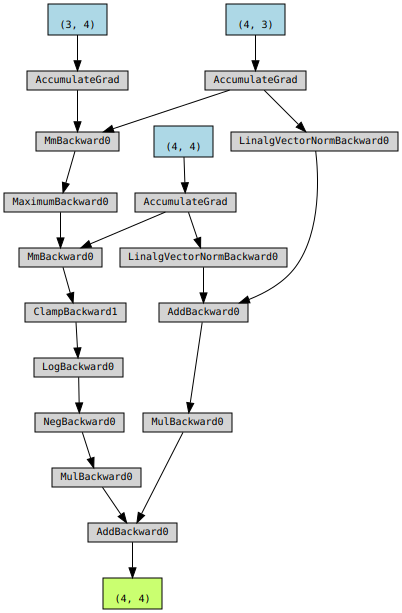

In [54]:
from torchviz import make_dot

# Plot the computational graph of J
graph = make_dot(J, params={'x': x, 'w_1': w_1, 'w_2': w_2,})
graph

## 3 BackPropagation

* Backprogation referes to the method of calculating the gradients of neural networks parameters.